# Acerca del dataset
El dataset que estaré utilizando se llama Weather Image Recognition. Este conjunto de datos contiene un total de 6862 imágenes etiquetadas que representan distintos tipos de condiciones climáticas. Está diseñado para tareas de clasificación de imágenes, donde el objetivo principal es que un modelo de machine learning o deep learning pueda identificar el tipo de clima predominante en una fotografía.

Las imágenes están organizadas en 11 clases diferentes, cada una representando un fenómeno climático específico:

- Dew (rocío)
- Fog/Smog (niebla o esmog)
- Frost (escarcha)
- Glaze (lluvia helada / hielo)
- Hail (granizo)
- Lightning (relámpagos)
- Rain (lluvia)
- Rainbow (arcoíris)
- Rime (cencellada)
- Sandstorm (tormenta de arena)
- Snow (nieve)

Cada clase está contenida en su propia carpeta, lo cual facilita el proceso de carga y etiquetado automático a través de frameworks como PyTorch o TensorFlow.

## Objetivo del Proyecto

Desarrollar un modelo de machine learning capaz de clasificar imágenes climáticas en una de las categorías definidas, utilizando un subconjunto del dataset **Weather Image Recognition**. 

El modelo deberá ser capaz de recibir una imagen como entrada y generar una predicción con las **3 clases más probables**

# Agregar las librerías
Aquí agregamos la librerías necesarias y cargamos el dataset de Kaggle.
Asimismo, imprimimos las clases que tenemos del dataset para analizar con lo que estamos trabajando.

In [44]:
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

base_path = Path("/kaggle/input/weather-dataset/dataset")

# Ver clases disponibles
clases = [d.name for d in base_path.iterdir() if d.is_dir()]
print(f"Available classes: {clases}")

Available classes: ['hail', 'rainbow', 'frost', 'rime', 'fogsmog', 'snow', 'rain', 'glaze', 'lightning', 'sandstorm', 'dew']


# Mostrar imágenes originales
En esta función estoy mostrando un subconjunto de las imágenes originales del dataset, esto con el objetivo para ir juszgando cuáles clases me convienen utilizar y cuáles no.

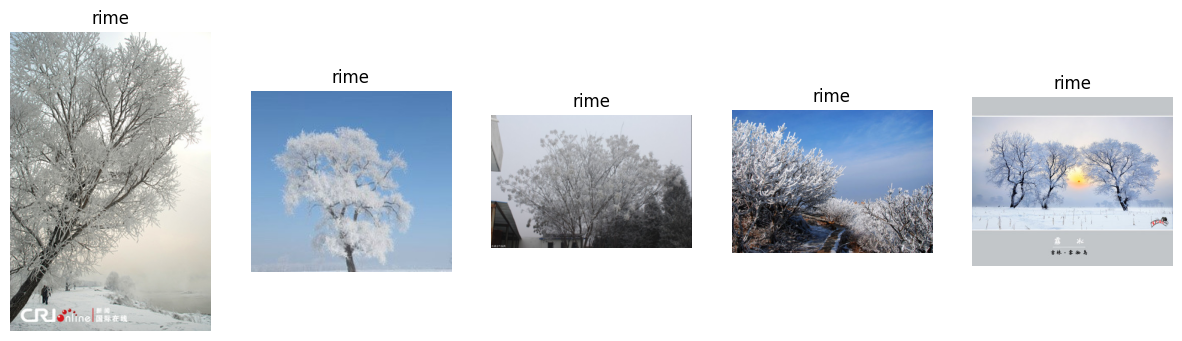

In [45]:
def show_images(weather, n=5):
    path = base_path / weather
    images = list(path.glob("*.jpg"))[:n]
    
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(weather)
        plt.axis('off')
    plt.show()

show_images("rime")

# Elección de clases
He decidio eliminar las clases de **dew**, **frost**, **frost**, **glaze** y **rime**, ya que estas considero que son ligeras variaciones de las clases rain y snow.

In [46]:
classes = ["rain", "lightning", "fogsmog", "hail", "rainbow", "sandstorm", "snow"]
data_dir = Path("/kaggle/working/weather_selected")
data_dir.mkdir(exist_ok=True)

for weather in classes:
    path = data_dir / weather
    path.mkdir(parents=True, exist_ok=True)
    origin = base_path / weather
    for img in list(origin.glob("*.jpg")):
        shutil.copy(img, path)

# Limpieza de los Datos

Como estamos trabajando con imágenes, la limpieza implica revisar visualmente:

- Imágenes corruptas (intentan abrirse pero fallan).
- Imágenes extremadamente pequeñas o borrosas.
- Imágenes en blanco o con errores de compresión.

En esta etapa, se realizó un muestreo aleatorio de imágenes para cada clase y se eliminaron manualmente aquellas que no cumplen con los estándares mínimos de calidad.


# Transformaciones y data set split

En esta sección, hago lo siguiente para preparar los datos antes de entrenar el modelo:

#### 1. **Transformaciones**
Se aplican transformaciones a las imágenes con **torchvision.transforms**:

- **Resize((64, 64))**: Redimensiona todas las imágenes a un tamaño uniforme de 64x64 píxeles.
- **ToTensor()**: Convierte las imágenes a tensores de PyTorch.
- **Normalize(mean=[0.5], std=[0.5])**: Normaliza los valores de los píxeles para que estén en un rango estándar (entre -1 y 1), lo cual ayuda a estabilizar el entrenamiento.

#### 2. **División del dataset**
El dataset completo se divide en tres subconjuntos:

- **70% entrenamiento** (train_ds)
- **15% validación** (val_ds)
- **15% prueba** (test_ds)

Finalmente, se crean los **DataLoader** correspondientes para cada conjunto con un batch_size de 32. El conjunto de entrenamiento se mezcla (shuffle=True) en cada epoch para mejorar la generalización del modelo.


In [ ]:
transformations = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transformations)

train_size = int(0.85 * len(dataset))
val_size = int(0.15 * len(dataset))

train_ds, val_ds = random_split(dataset, [train_size, val_size + test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

class_names = dataset.classes

In [48]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

class RNNModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_layers=3, num_classes=len(classes)):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size * 64, num_classes)

    def forward(self, x):
        x = x.mean(1)  
        out, _ = self.rnn(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Accuracy: {train_acc:.2f}%, Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Validation Accuracy: {val_acc:.2f}%, Validation Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/10]
Train Accuracy: 47.63%, Train Loss: 1.4136
Validation Accuracy: 53.52%, Validation Loss: 1.1894
Epoch [2/10]
Train Accuracy: 56.19%, Train Loss: 1.1624
Validation Accuracy: 56.09%, Validation Loss: 1.1463
Epoch [3/10]
Train Accuracy: 59.24%, Train Loss: 1.0853
Validation Accuracy: 56.95%, Validation Loss: 1.0871
Epoch [4/10]
Train Accuracy: 60.89%, Train Loss: 1.0248
Validation Accuracy: 57.80%, Validation Loss: 1.0514
Epoch [5/10]
Train Accuracy: 62.69%, Train Loss: 1.0000
Validation Accuracy: 59.86%, Validation Loss: 1.0485
Epoch [6/10]
Train Accuracy: 64.71%, Train Loss: 0.9418
Validation Accuracy: 61.41%, Validation Loss: 1.0289
Epoch [7/10]
Train Accuracy: 66.65%, Train Loss: 0.8808
Validation Accuracy: 58.66%, Validation Loss: 1.0631
Epoch [8/10]
Train Accuracy: 68.67%, Train Loss: 0.8258
Validation Accuracy: 58.66%, Validation Loss: 1.1385
Epoch [9/10]
Train Accuracy: 70.36%, Train Loss: 0.7844
Validation Accuracy: 57.63%, Validation Loss: 1.1031
Epoch [10/10]
Train

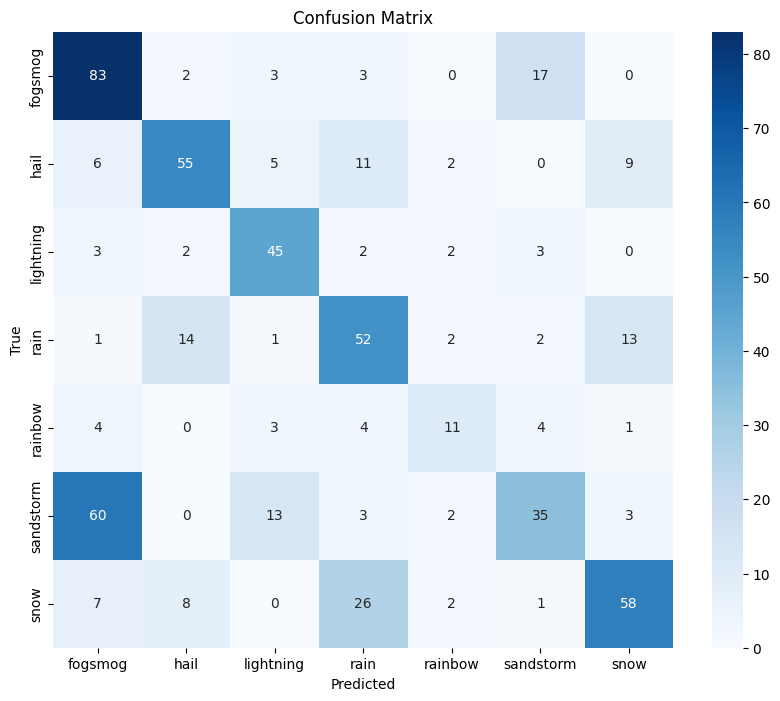

In [50]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [51]:
from torchvision.transforms import ToTensor

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transformations(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img)
        probs = F.softmax(pred, dim=1)
        top3 = torch.topk(probs, 3)
        for i in range(3):
            clase_idx = top3.indices[0][i].item()
            prob = top3.values[0][i].item()
            print(f"{dataset.classes[clase_idx]}: {prob*100:.2f}%")

personal_imgs = Path("/kaggle/input/my-personal-weather-images/test")

for img_file in personal_imgs.glob("*.jpg"):
    print(f"\nPredicción para {img_file.name}:")
    predict_image(img_file)



Predicción para lluvia-3-e1581819535291.jpg:
rainbow: 33.44%
snow: 29.79%
lightning: 19.58%

Predicción para gettyimages-624719836-612x612.jpg:
fogsmog: 53.94%
sandstorm: 41.41%
rain: 2.80%


In [ ]:
class CNNModel(nn.Model()):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

AttributeError: module 'torch.nn' has no attribute 'Model'

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Accuracy: {train_acc:.2f}%, Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Validation Accuracy: {val_acc:.2f}%, Validation Loss: {val_loss/len(val_loader):.4f}")


In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()